# Single Harmonic
This looks at how much information can be extracted about the seasonal cycle, restricting ourselves to a single harmonic.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [60]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf', 'ucomp', 'vcomp', 'w_atm']
# Load dataset

# # DEFAULT experiment
# exp_dir = 'tau_sweep/aquaplanet/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}" for i in range(n_exp)]

# # Experiment with no-WISHE and no convection
# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]

# exp_dir = 'aquaplanet/no_wishe/'
# exp_name = ["k=1"]

exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = ['evap=0_1']
# exp_dir = 'aquaplanet/latent_heat_temp_only/depth=20/'
# exp_name = ['base']


# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

n_exp = len(exp_name)
lat_range = slice(30, 60)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)
    lapse = ds_use.temp.sel(pfull=500, method='nearest') - ds_use.temp.sel(pfull=np.inf, method='nearest')
    ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = ds_use.lwdn_sfc/(Stefan_Boltzmann*ds_use.temp**4)
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp
    ds_use['rh'] = ds_use.sphum / sphum_sat(ds_use.temp, ds_use.ps*sigma_near_surf)
    ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
    ds_base += [ds_use.load()]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]

is_wishe=True
try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
    if w_atm_const > 0:
        is_wishe=False
        for i in range(n_exp):
            # Set wind to the constant value if it is set in namelist
            ds_base[i]['w_atm'] = ds_base[i]['w_atm']*0+w_atm_const
except KeyError:
    w_atm_const = np.nan

try: 
    rh_flux_q = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['rh_flux_q']
except KeyError:
    rh_flux_q = 0
try:
    evap_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['land_evap_prefactor']
except KeyError:
    evap_prefactor = 1

  0%|          | 0/1 [00:00<?, ?it/s]

Removing height from var_keep


100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [4]:
def get_annual_zonal_mean(ds):
    ds_av = annual_mean(ds).mean(dim='lon')
    ds_av = ds_av.assign_coords(time=(ds_av.time - ds_av.time.min()).astype(int))
    return ds_av

In [5]:
ds = get_annual_zonal_mean(ds_base[0])
p_surface = float(ds.pfull)*100
if isinstance(w_atm_const, (int, float)):
    if w_atm_const == 0 or w_atm_const == np.nan:
        w_atm_const = ds.w_atm.mean(dim='time')

In [6]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds.lat.size
n_time = ds.time.size
t_surf = ds.t_surf.to_numpy().transpose()
t_surf_anom = t_surf - np.mean(t_surf, axis=1)[:, np.newaxis]

## How many harmonics required?
Here we look fit a fourier expansion of a given number of harmonics directly to the temperature and shortwave radiation. It seems that there is a large reduction in error as we go from 1 to 2 harmonics, but not much more is gained by including more than 2 harmonics.

The surface energy budget is 
$$
C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}
= SW^{\downarrow} - \Gamma^{\downarrow}
$$

If we can approximate $\Gamma^{\downarrow} \approx \lambda_0 + \lambda T'(t)$ then an analytic solution for temperature anomaly $T'(t)$ is possible. Given this linear approximation, we look at the effect of increasing the number of harmonics. 

It seems that at latitudes less than $60\degree$ that no improvement can be made by increasing the number of harmonics, given the linear approximation of $\Gamma$.

Hence it makes sense to just look at the single harmonic solution but try and improve the approximation of $\Gamma$.

In [7]:
sw_amp_coefs = {key: np.zeros((n_lat, 1+int(key.replace('_harmonic', '')))) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
sw_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
temp_anom_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
for key in sw_amp_coefs:
    for i in range(n_lat):
        sw_amp_coefs[key][i] = fourier.get_fourier_fit(ds.time, ds.swdn_sfc[:, i], n_time, int(key.replace('_harmonic', '')))[1]
        # Fit SW fourier with no phase
        sw_fourier_fit[key][i] = fourier.fourier_series(ds.time, n_time, sw_amp_coefs[key][i], np.zeros(int(key.replace('_harmonic', ''))))
        temp_anom_fourier_fit[key][i] = fourier.get_fourier_fit(ds.time, t_surf_anom[i], n_time, int(key.replace('_harmonic', '')))[0]
    temp_anom_fourier_fit[key] = temp_anom_fourier_fit[key] - np.mean(temp_anom_fourier_fit[key], axis=1)[:, np.newaxis]
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation 
time_extrema_sw = {'min': int(ds.time[0]), 'max': int(ds.time[int(ds.time.size/2)])}
time_extrema_temp = {key: {'simulated': np.zeros(n_lat), 'direct fit': np.zeros(n_lat)} for key in ['min', 'max']}
amp_extrema_temp = {key: {'simulated': np.zeros(n_lat), 'direct fit': np.zeros(n_lat)} for key in ['min', 'max']}

smooth_ndays_temp_extrema = 20            # smoothing to temp annual mean to find date of hottest day
for key in time_extrema_temp['min']:
    for i in range(n_lat):
        # No smoothing for '1_harmonic' as already fit smooth fourier solution
        time_extrema_temp['min'][key][i], time_extrema_temp['max'][key][i], amp_extrema_temp['min'][key][i], amp_extrema_temp['max'][key][i] = \
            get_temp_extrema_numerical(ds.time, temp_anom_fourier_fit['1_harmonic'][i] if key=='direct fit' else t_surf_anom[i], 
                                       1 if key=='direct fit' else smooth_ndays_temp_extrema)

In [8]:
# General plotting info
plot_lat_ind = 6
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_time = [ds.time[0]-1, ds.time[-1]+1]
ax_lims_lat = [np.floor(ds.lat[0]), np.ceil(ds.lat[-1])]
color_approx = {'simulated': 'k', 'direct fit': 'k', 'linear': default_colors[0], '1_harmonic': 'k',
                'lw': default_colors[3], 'lh': default_colors[1], 'sh': default_colors[2], 'linear_phase': default_colors[0]}
color_extrema = {'max': default_colors[3], 'min': default_colors[0]}
linestyle_approx = {'simulated': '-', 'direct fit': ':', 'linear': ':', '1_harmonic': ':', 'linear_phase': '--', 'linear_phase_0': '-'}
color_harmonic = {'1_harmonic': 'k', '2_harmonic': default_colors[1], '5_harmonic': default_colors[3]}
color_var = {'sum': 'k', 'w_atm': default_colors[2], 'drag_q': default_colors[1], 'rh': default_colors[0], 'temp_diseqb': default_colors[4], 
             'ps': default_colors[5], 'emission_factor': default_colors[0], 't_surf': default_colors[3]}
var_unit_labels = {'w_atm': '[ms$^{-1}$]', 'drag_q': None, 'rh': None, 'temp_diseqb': '[K]', 'ps': '[Pa]', 'emission_factor': None}

# Define error func to use
error_func_dict = {'max': lambda x, x_approx, norm=False, axis=1: np.max(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'median': lambda x, x_approx, norm=False, axis=1: np.median(np.abs(x - x_approx), axis=axis) / 
                                                                 (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1), 
                   'mean': lambda x, x_approx, norm=False, axis=1: np.mean(np.abs(x - x_approx), axis=axis) / 
                                                                  (0.01*x.max(axis=axis)-0.01*x.min(axis=axis) if norm else 1)}
error_func_use = 'mean'
error_func = error_func_dict[error_func_use.lower()]

# Whether to show plots with smoothing of simulated values done or not. Theoretical curves always shown without smoothing
# Will also smooth simulated var but not approximated var before calculating error
# Fitting is always done with no smoothing performed first.
plot_smooth = True
if plot_smooth:
    smooth_func = lambda x, ax=-1: scipy.ndimage.convolve1d(x, np.ones(smooth_ndays_temp_extrema)/smooth_ndays_temp_extrema, mode='wrap', axis=ax)
else:
    smooth_func = lambda x, ax=0: x

In [9]:
fig_sw_temp_sl, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[0].plot(ds.time, ds.swdn_sfc[:, plot_lat_ind], color='k', label='Simulated')

ax[1].plot(ds.time, smooth_func(t_surf_anom[plot_lat_ind]), color='k', label='Simulated')
for key in time_extrema_sw:
    ax[0].scatter(time_extrema_sw[key], ds.swdn_sfc.sel(time=time_extrema_sw[key])[plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    ax[1].scatter(time_extrema_temp[key]['simulated'][plot_lat_ind], (-1 if key=='min' else 1) * amp_extrema_temp[key]['simulated'][plot_lat_ind],
                       color='grey', marker='|', s=1000, lw=2.5, alpha=0.5)
    
ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$SW^{\\downarrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel('$T - \overline{T}$ [K]')
ax[0].legend()
fig_sw_temp_sl.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$; "
             f"$\delta_{'{min}'}$={round(time_extrema_temp['min']['simulated'][plot_lat_ind]-time_extrema_sw['min'], 1)}; "
             f"$\delta_{'{max}'}$={round(time_extrema_temp['max']['simulated'][plot_lat_ind]-time_extrema_sw['max'], 1)} days", fontsize=8, y=0.93)
plt.close()

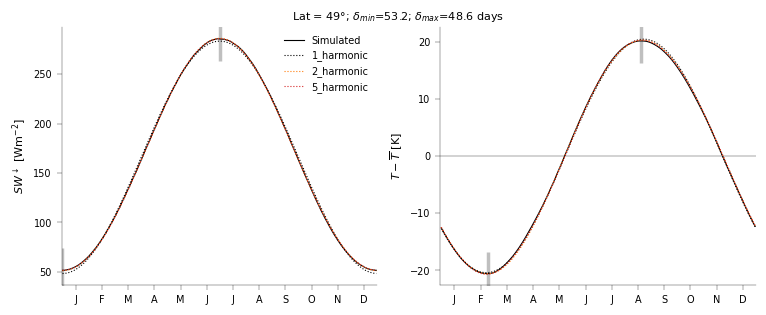

In [10]:
fig = copy.deepcopy(fig_sw_temp_sl)
ax = np.asarray(fig.axes)
for key in sw_fourier_fit:
    ax[0].plot(ds.time, sw_fourier_fit[key][plot_lat_ind], color=color_harmonic[key], linestyle=linestyle_approx['1_harmonic'], label=key)
    ax[1].plot(ds.time, temp_anom_fourier_fit[key][plot_lat_ind], 
               color=color_harmonic[key], linestyle=linestyle_approx['1_harmonic'])
    ax[0].legend()
fig

In [11]:
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
gamma = {'simulated':np.asarray(ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t).transpose(), 
         'linear': np.zeros((n_lat, n_time))}
gamma_params = {'linear': np.zeros((n_lat, 2))}      # lowest power is last


temp_anom_linear_harmonics = {key: np.zeros((n_lat, n_time)) for key in sw_fourier_fit}
for i in range(n_lat):
    gamma_params['linear'][i] = np.polyfit(t_surf_anom[i], gamma['simulated'][i], 1)
    gamma['linear'][i] = numerical.apply_polyfit(t_surf_anom[i], gamma_params['linear'][i])
    for key in temp_anom_linear_harmonics:
        temp_anom_linear_harmonics[key][i] = get_temp_fourier_analytic(ds.time, ds.swdn_sfc.isel(lat=i), heat_capacity, gamma_params['linear'][i][0], 
                                                                  n_harmonics_sw=int(key.replace('_harmonic', '')))[0]


Text(0.5, 0.02, 'Latitude [deg]')

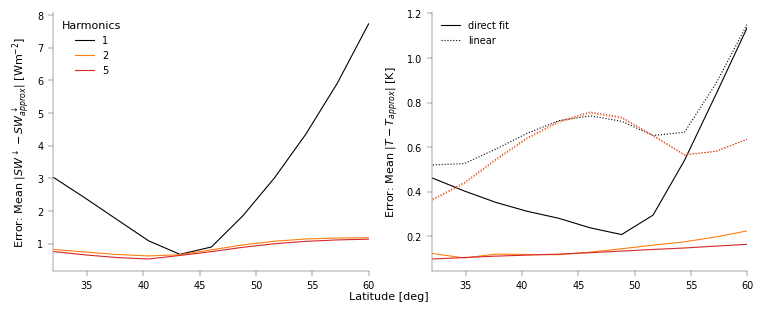

In [12]:
fig_error_sw, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=False)
for key in sw_fourier_fit:
    ax[0].plot(ds.lat, error_func(smooth_func(ds.swdn_sfc.transpose().to_numpy()), sw_fourier_fit[key], norm=False), color=color_harmonic[key],
               label=key.replace('_harmonic', ''))
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_fourier_fit[key], norm=False), color=color_harmonic[key],
               label='direct fit' if '1' in key else None)
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_linear_harmonics[key], norm=False), color=color_harmonic[key],
               label='linear' if '1' in key else None, linestyle=linestyle_approx['linear'])
    
ax[0].legend(title='Harmonics')
ax[1].legend()
ax[0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|SW^{\\downarrow} - SW^{\\downarrow}_{approx}|$ [Wm$^{-2}$]')
ax[1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
ax[0].set_xlim(ax_lims_lat)
fig_error_sw.supxlabel('Latitude [deg]', fontsize=8, y=0.02)
# isca_tools.savefig(fig_error_sw, 'harmonic_error', save_if_exists=False)

## Best Possible Estimate from just single harmonic

Additional powers of temperature in the $\Gamma$ approximation e.g. $\lambda_{sq}T'^2(t)$ would lead to terms of higher order than 1 harmonic in the surface energy budget, thus these cannot be the cause of the discrepancy of the linear $\Gamma$ approximation.

Looking at the $\Gamma$ plot below, there seems to be some hysteresis, which can be explained with a single harmonic. We thus seek an approximation of $\Gamma$ of the following form with three parameters that need to be found:

$\Gamma(t) \approx \lambda_0 + \lambda T(t) + \lambda_{phase} T(t-90)$

The phase delay is 90 days, as this refers to a quarter of the cycle (year has 360 days). This is clear to the eye, once all non phase shifted temperature dependence has been removed.

We do this fitting for each component of $\Gamma$ individually, so we have an idea of where the phase delay is coming from.

Clearly this phase term makes up almost the entire difference to the direct fit.

In [13]:
key = 'simulated'
gamma_comp_params = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp = {key: {} for key in ['lw', 'lh', 'sh']}
gamma_comp['lw'][key] = (ds.lwup_sfc-ds.lwdn_sfc).transpose().to_numpy()
gamma_comp['lh'][key] = (ds.flux_lhe).transpose().to_numpy()
gamma_comp['sh'][key] = (ds.flux_t).transpose().to_numpy()

n_approx_params = {'linear': 2, 'linear_phase': 3}
for key in ['linear', 'linear_phase']:
    for key2 in gamma_comp:
        gamma_comp_params[key2][key] = np.zeros((n_lat, n_approx_params[key]))
        gamma_comp[key2][key] = np.zeros((n_lat, n_time))
        for i in range(n_lat):
            if 'phase' in key:
                gamma_comp_params[key2][key][i] = numerical.polyfit_phase(t_surf_anom[i], gamma_comp[key2]['simulated'][i],
                                                                          n_approx_params[key.replace('_phase', '')] - 1, ds.time.to_numpy())
                gamma_comp[key2][key][i] = numerical.polyval_phase(t_surf_anom[i], gamma_comp_params[key2][key][i])
            else:
                gamma_comp_params[key2][key][i] = np.polyfit(t_surf_anom[i], gamma_comp[key2]['simulated'][i], n_approx_params[key]-1)
                gamma_comp[key2][key][i] = numerical.apply_polyfit(t_surf_anom[i], gamma_comp_params[key2][key][i])

In [14]:
temp_anom_approx = {'linear': temp_anom_linear_harmonics['1_harmonic']}
for key in ['linear_phase']:
    temp_anom_approx[key] = np.zeros((n_lat, n_time))
    gamma_params[key] = np.zeros((n_lat, 3))
    gamma[key] = np.zeros((n_lat, n_time))
    for i in range(1, 3):
        gamma_params[key][:, -i] = gamma_comp_params['lw'][key][:, -i]+gamma_comp_params['lh'][key][:, -i]+gamma_comp_params['sh'][key][:, -i]
    if 'phase' in key:
        gamma_params[key][:, 0] = gamma_comp_params['lw'][key][:, 0]+gamma_comp_params['lh'][key][:, 0]+gamma_comp_params['sh'][key][:, 0]
    for i in range(n_lat):
        gamma[key][i] = numerical.polyval_phase(t_surf_anom[i], gamma_params[key][i])
        temp_anom_approx[key][i] = get_temp_fourier_analytic(ds.time, ds.swdn_sfc.isel(lat=i), heat_capacity, gamma_params[key][i, -2], 
                                                             gamma_params[key][i, 0], n_harmonics_sw=1)[0]
    if np.abs(temp_anom_approx[key].mean(axis=1)).max()>1e-12:
        raise ValueError('Fourier fit should have returned anomaly but mean is non-zero')

temp_anom_approx['linear_phase_numerical'] = np.zeros((n_lat, n_time))
for i in range(n_lat):
    temp_anom_approx['linear_phase_numerical'][i] = \
        get_temp_fourier_numerical(ds.time.to_numpy(), t_surf_anom[i], gamma['simulated'][i], 
                                   sw_fourier_fit['1_harmonic'][i], heat_capacity, n_harmonics=1, deg_gamma_fit=1)

Text(0.5, 0.93, 'Lat = $49\\degree$')

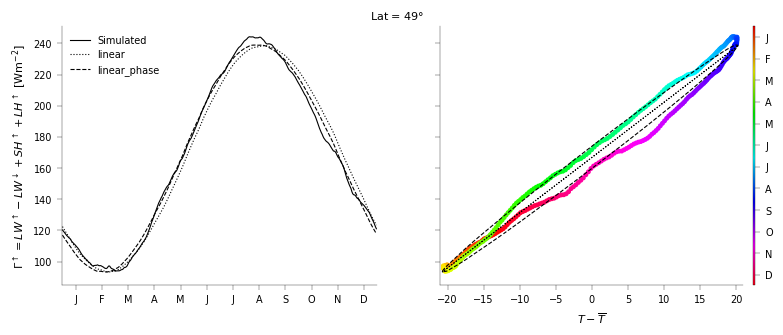

In [15]:
fig_sl_gamma, ax = plt.subplots(1,2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharey=True)
ax[0].plot(ds.time, smooth_func(gamma['simulated'][plot_lat_ind]), color='k', label='Simulated')
im = ax[1].scatter(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(gamma['simulated'][plot_lat_ind]), c=ds.time, cmap='hsv')
for key in ['linear', 'linear_phase']:
    ax[0].plot(ds.time, gamma[key][plot_lat_ind], color='k', linestyle=linestyle_approx[key], label=key)
    ax[1].plot(t_surf_anom[plot_lat_ind], gamma[key][plot_lat_ind], color='k', linestyle=linestyle_approx[key], label=key)

cbar = fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_ylabel('$\Gamma^{\\uparrow} = LW^{\\uparrow} - LW^{\\downarrow} + SH^{\\uparrow} + LH^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_xlabel('$T - \overline{T}$')
ax[1].set_xlim(-np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()), np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()))
ax[1].set_ylim(np.floor(gamma['simulated'][plot_lat_ind].min()), np.ceil(gamma['simulated'][plot_lat_ind].max()))
ax[0].legend()
ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
fig_sl_gamma.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=8, y=0.93)
# isca_tools.savefig(fig_sl_gamma, f'gamma_fit_lat={ds.lat[plot_lat_ind]:.0f}', save_if_exists=False)

Text(0.5, 0.01, 'Latitude [deg]')

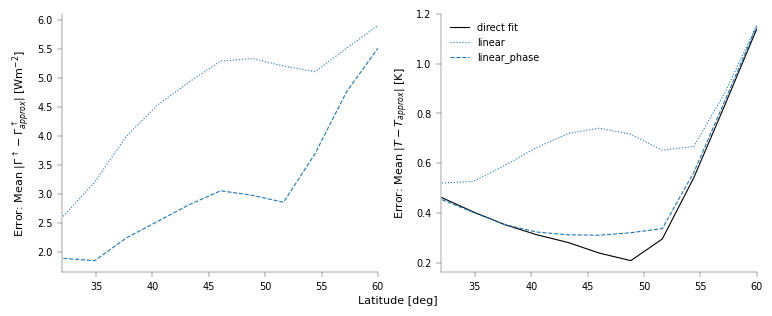

In [16]:
fig_error, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_fourier_fit['1_harmonic']), color='k',
           label='direct fit')
for key in ['linear', 'linear_phase']:
    ax[0].plot(ds.lat, error_func(smooth_func(gamma['simulated']), gamma[key]), color=color_approx['linear'],
               label=key, linestyle=linestyle_approx[key])
    ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_approx[key]), color=color_approx['linear'], 
               label=key, linestyle=linestyle_approx[key])
# ax[1].plot(ds.lat, error_func(smooth_func(t_surf_anom), temp_anom_approx['1_harmonic_best']), color='r', 
#                label=key, linestyle=linestyle_approx[key])
ax[1].legend()
ax[0].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|\Gamma^{\\uparrow} - \Gamma^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[1].set_ylabel(f'Error: {error_func_use.capitalize()} '+'$|T - T_{approx}|$ [K]')
ax[0].set_xlim(ax_lims_lat)
fig_error.supxlabel('Latitude [deg]', fontsize=8)
# isca_tools.savefig(fig_error, f'gamma_temp_error', save_if_exists=False)

### Explicit effect of $\lambda_{phase}$
Below we see that the effect of non-zero $\lambda_{phase}$ is to shift the extrema later and reduce the amplitude.

In [17]:
for key in ['linear_phase_0']:
    temp_anom_approx[key] = np.zeros((n_lat, n_time))
    for i in range(n_lat):
        temp_anom_approx[key][i] = get_temp_fourier_analytic(ds.time, ds.swdn_sfc.isel(lat=i), heat_capacity, 
                                                             gamma_params[key.replace('_0', '')][i, -2], n_harmonics_sw=1)[0]
    if np.abs(temp_anom_approx[key].mean(axis=1)).max()>1e-12:
        raise ValueError('Fourier fit should have returned anomaly but mean is non-zero')

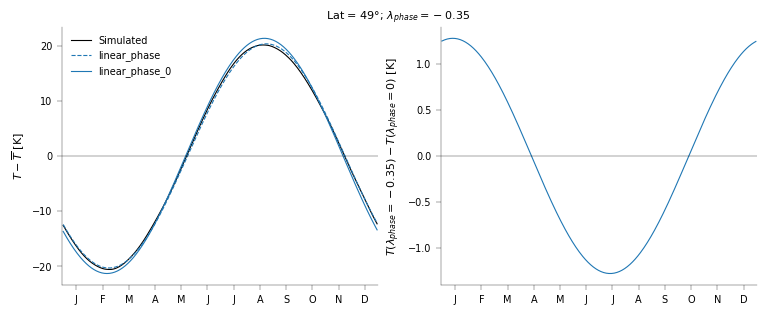

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
show_sanity_check=False
ax[0].plot(ds.time, smooth_func(t_surf_anom[plot_lat_ind]), color='k', label='Simulated')
for approx_plot in ['linear_phase']:
    for key2 in [approx_plot, approx_plot+'_0']:
        ax[0].plot(ds.time, temp_anom_approx[key2][plot_lat_ind], color=color_approx[approx_plot], 
                              linestyle=linestyle_approx[key2], label=key2)
    ax[1].plot(ds.time, (temp_anom_approx[approx_plot][plot_lat_ind]) -
               (temp_anom_approx[approx_plot+'_0'][plot_lat_ind]),
               color=color_approx[approx_plot], label='analytical')
    if show_sanity_check:
        ax[1].plot(ds.time, (temp_anom_approx[approx_plot+'_numerical'][plot_lat_ind]) -
           (temp_anom_approx[approx_plot+'_0'][plot_lat_ind]),
           color='r', linestyle=':', label='numerical')

ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*month_ticks)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$T - \overline{T}$ [K]')
ax[0].legend()
if show_sanity_check:
    ax[1].legend()
ax[1].set_ylabel(f'$T(\lambda_{"{phase}"}={gamma_params["linear_phase"][plot_lat_ind, 0]:.2g}) - T(\lambda_{"{phase}"}= 0)$ [K]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$; "
             f"$\lambda_{'{phase}'}={gamma_params[approx_plot][plot_lat_ind, 0]:.2g}$", fontsize=8, y=0.93);
# isca_tools.savefig(fig, f'phase_fit_lat={ds.lat[plot_lat_ind]:.0f}', save_if_exists=False)

## Breakdown of $\Gamma$
Below we see the phasing correction mainly comes from the latent heat flux, but the sensible heat is also significant.

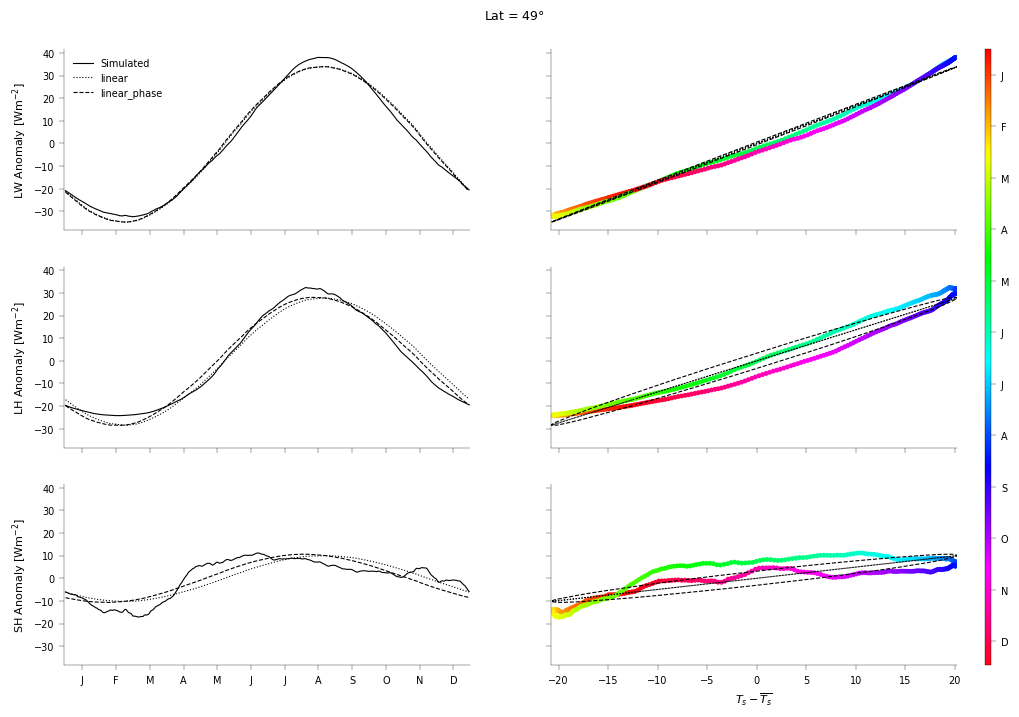

In [19]:
fig, ax = plt.subplots(3,2, figsize=(12, 8), sharey=True, sharex='col')
for i, key in enumerate(gamma_comp):
    ax[i, 0].plot(ds.time, smooth_func(gamma_comp[key]['simulated'][plot_lat_ind]-
                                       gamma_comp[key]['simulated'][plot_lat_ind].mean()), color='k', label='Simulated')
    im = ax[i, 1].scatter(smooth_func(t_surf_anom[plot_lat_ind]),
                          smooth_func(gamma_comp[key]['simulated'][plot_lat_ind]-gamma_comp[key]['simulated'][plot_lat_ind].mean()),
                          c=ds.time, cmap='hsv')
    for key2 in ['linear', 'linear_phase']:
        ax[i, 0].plot(ds.time, gamma_comp[key][key2][plot_lat_ind]-gamma_comp[key][key2][plot_lat_ind].mean(),
                      color='k', linestyle=linestyle_approx[key2], label=key2)
        ax[i, 1].plot(t_surf_anom[plot_lat_ind], gamma_comp[key][key2][plot_lat_ind]-gamma_comp[key][key2][plot_lat_ind].mean(),
                      color='k', linestyle=linestyle_approx[key2])
    ax[i, 0].set_ylabel(key.upper() + ' Anomaly [Wm$^{-2}$]')
    # fit_param = optimize.curve_fit(square_func, t_surf_anom[no_conv_time_ind], var[no_conv_time_ind], [80, 3, 0])[0]
    # ax[i, 0].plot(ds.time, square_func(t_surf_anom, *fit_param), color='g', linestyle='--', label='Square fit (non convecting)')
    # ax[i, 1].plot(t_surf_anom, square_func(t_surf_anom, *fit_param), color='g', linestyle='--')
ax[0, 0].set_xlim(-1, 360)
ax[0, 1].set_xlim(t_surf_anom[plot_lat_ind].min(), t_surf_anom[plot_lat_ind].max())
ax[0, 0].legend()
ax[-1, 0].set_xticks(*month_ticks)
ax[-1, 1].set_xlabel('$T_s - \overline{T_s}$')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

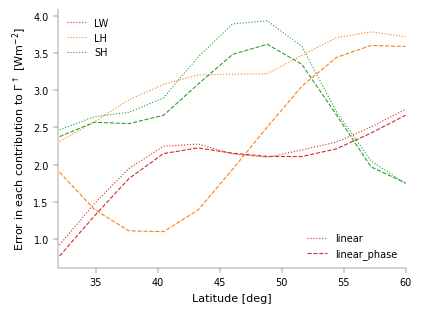

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
lines = []
for key2 in ['linear', 'linear_phase']:
    for key in gamma_comp:
        lines += [ax.plot(ds.lat, error_func(smooth_func(gamma_comp[key]['simulated']), gamma_comp[key][key2], norm=False), color=color_approx[key],
                   label=key.upper(), linestyle=linestyle_approx[key2])[0]]
legend1 = ax.legend(handles=lines[:3], loc="upper left")
ax.add_artist(legend1)  # Add the first legend manually

# Second legend
ax.legend(handles=lines[::len(gamma_comp)], loc="lower right", labels=['linear', 'linear_phase'])
ax.set_ylabel('Error in each contribution to $\Gamma^{\\uparrow}$ [Wm$^{-2}$]')
ax.set_xlim(ax_lims_lat)
ax.set_xlabel('Latitude [deg]');
# isca_tools.savefig(fig, f'gamma_cont_error', save_if_exists=False)

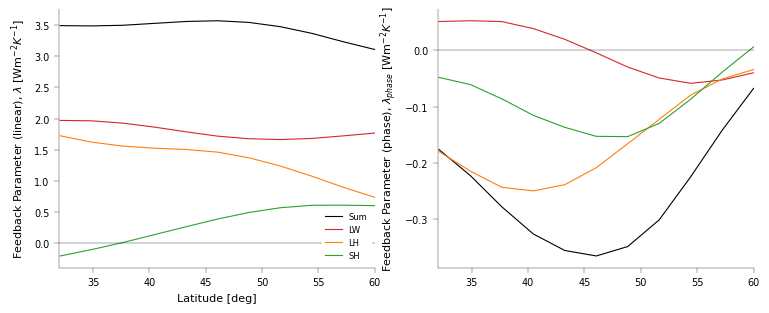

In [21]:
key = 'linear_phase'
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(len(ax)):
    ax[i].plot(ds.lat, gamma_params[key][:, 1-i], color='k', label='Sum')
    for key2 in gamma_comp_params:
        ax[i].plot(ds.lat, gamma_comp_params[key2][key][:, 1-i], color=color_approx[key2], label=key2.upper())

ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend(loc='lower right', frameon=True, framealpha=1, edgecolor='white', fontsize=6)
ax[0].set_xlim(ax_lims_lat)
ax[0].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Feedback Parameter (linear), $\lambda$ [Wm$^{-2}K^{-1}$]')
ax[1].set_ylabel('Feedback Parameter (phase), $\lambda_{phase}$ [Wm$^{-2}K^{-1}$]');
# isca_tools.savefig(fig, f'gamma_cont_param', save_if_exists=False)

## Extrema
Next we look at the times and amplitudes of the extrema. We are restricting ourselves to a single harmonic, so phase and amplitude are constrained to be the same. 

The effect of $\lambda_{phase}$ is again clear here - reducing amplitude of extrema and shifting them to occur later in the year i.e. an increase in effective heat capacity. 

Again the linear_phase line almost exactly matches the direct fit, indicating it is the best we can do for a single harmonic.

The contrasting latitudinal trends in phase of maxima and minima require additional harmonics to explain.

In [22]:
for key in ['linear', 'linear_phase', 'linear_phase_0']:
    time_extrema_temp['min'][key], time_extrema_temp['max'][key], amp_extrema_temp['min'][key], amp_extrema_temp['max'][key] = \
    get_temp_extrema_analytic(sw_amp_coefs['1_harmonic'][:, 1], heat_capacity, gamma_params[key.replace('_0', '')][:, -2], 
                              gamma_params[key][:, 0] if key=='linear_phase' else 0)
    

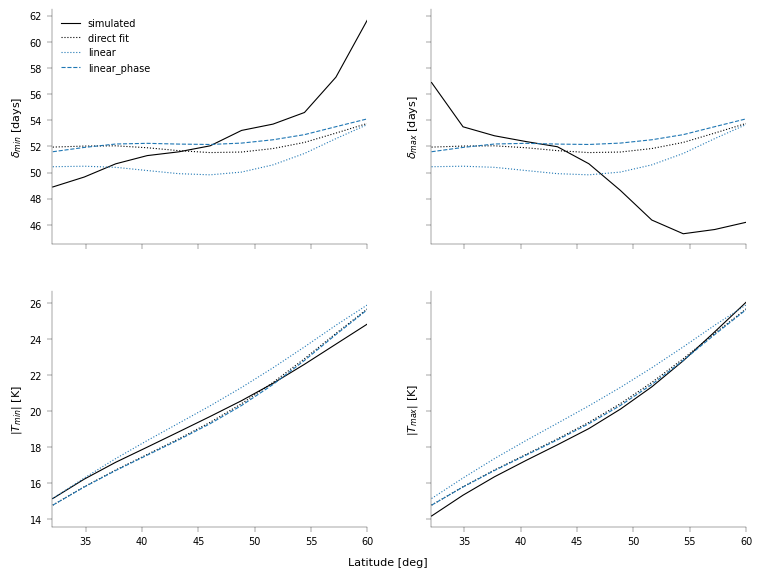

In [23]:
fig_extrema, ax = plt.subplots(2, 2, figsize=(im_sz*2*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True, sharey='row')
for i, key in enumerate(time_extrema_temp):
    for key2 in ['simulated', 'direct fit', 'linear', 'linear_phase']:
        ax[0, i].plot(ds.lat, time_extrema_temp[key][key2] - time_extrema_sw[key], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2], label=key2)
        ax[1, i].plot(ds.lat, amp_extrema_temp[key][key2], color=color_approx[key2], 
                      linestyle=linestyle_approx[key2])
    ax[0, i].set_ylabel(f"$\delta_{'{'+key+'}'}$ [days]")
    ax[1, i].set_ylabel(f"$|T_{'{'+key+'}'}|$ [K]")
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].legend()
fig_extrema.supxlabel('Latitude [deg]', fontsize=8, y=0.05);
# isca_tools.savefig(fig_extrema, f'extrema', save_if_exists=False)

## Physical Interpretation of $\lambda$ and $\lambda_{phase}$
Now we try to get an idea of what sets the magnitude and latitudinal trend in $\lambda$ and $\lambda_{phase}$. We consider each flux contribution to $\lambda$ and $\lambda_{phase}$ in turn.
### Latent Heat

The [equation](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L598) used for latent heat flux by Isca is: $LH = f_{evap}L_v C_q\rho |v|(q^*(T_s, p_s) - q_{a})$

where $f_{evap}=0.1$ is the evaporative prefactor for this experiment.

So given that $q_a = r_aq^*(T_a, p_a)$; $\rho = p_a/RT_a$ where $T_a = T_s - T_{diseqb}$ and $p_a = \sigma_ap_s$, latent heat is only a function of 6 variables:

* Surface temperature, $T_s$
* Disequilibrium temperature, $T_{diseqb}$
* Relative humidity, $r_a$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$.

In [24]:
def get_latent_heat(temp_surf, temp_diseqb, rh, wind_speed, drag_coef, p_surf, sigma=sigma_near_surf, evap_prefactor=evap_prefactor):
    temp_a = temp_surf - temp_diseqb
    p_a = p_surf*sigma
    rho = get_density(temp_a, p_a)
    sphum_a = rh * sphum_sat(temp_a, p_a)
    return evap_prefactor * L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

In [25]:
ds_mean = ds.mean(dim='time')
lh_manual = {'all_cont': get_annual_zonal_mean(get_latent_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].rh,
                                                               ds_base[0].w_atm, ds_base[0].drag_q, ds_base[0].ps)),
             'all_cont_av_first': get_latent_heat(ds.t_surf, ds.temp_diseqb, ds.rh, ds.w_atm, ds.drag_q, ds.ps),
             'mean': get_latent_heat(ds_mean.t_surf, ds_mean.temp_diseqb, ds_mean.rh, ds_mean.w_atm,
                                       ds_mean.drag_q, ds_mean.ps)}

alpha_s = clausius_clapeyron_factor(ds_mean.t_surf, ds_mean.ps)
q_sat_s = sphum_sat(ds_mean.t_surf, ds_mean.ps)
alpha_a = clausius_clapeyron_factor(ds_mean.temp, sigma_near_surf*ds_mean.ps)
q_sat_a = sphum_sat(ds_mean.temp, sigma_near_surf*ds_mean.ps)
ds_mean['rho_calc'] = get_density(ds_mean.temp, sigma_near_surf*ds_mean.ps)
lh_prefactor = evap_prefactor*L_v*ds_mean.drag_q*ds_mean.w_atm*ds_mean.rho_calc

lh_taylor = {'t_surf': -lh_manual['mean']/ds_mean['temp'] + lh_prefactor*(alpha_s*q_sat_s-ds_mean.rh*alpha_a*q_sat_a),
             'temp_diseqb': lh_manual['mean']/ds_mean['temp'] + lh_prefactor*ds_mean.rh*alpha_a*q_sat_a,
             'rh': -lh_prefactor*q_sat_a}
for key in ['w_atm', 'drag_q', 'ps']:
    lh_taylor[key] = lh_manual['mean']/ds_mean[key]
lh_taylor['sum'] = 0
for key in lh_taylor:
    if key=='sum':
        continue
    lh_taylor['sum'] += (lh_taylor[key]*(ds[key]-ds_mean[key]))
lh_taylor['sum'] = lh_taylor['sum'] + lh_manual['mean']
lh_taylor['t_surf_square'] = -lh_taylor['t_surf']/ds_mean.temp + lh_manual['mean']/ds_mean.temp**2+lh_prefactor*(
    alpha_s*q_sat_s/ds_mean.t_surf * (alpha_s*ds_mean.t_surf-2) - ds_mean.rh*alpha_a*q_sat_a/ds_mean.temp * (alpha_a*ds_mean.temp-2)
)
lh_taylor['t_surf_square']  = lh_taylor['t_surf_square']*0.5
lh_taylor['t_surf_w_atm'] = lh_taylor['t_surf']/ds_mean.w_atm
lh_taylor['t_surf_rh'] = -lh_prefactor * alpha_a*q_sat_a

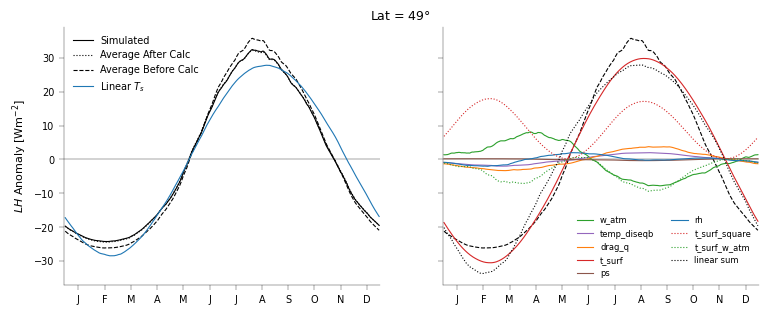

In [26]:
fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)

ax[0].plot(ds.time, smooth_func(ds.flux_lhe.isel(lat=plot_lat_ind)-ds.flux_lhe.isel(lat=plot_lat_ind).mean()), color='k', label='Simulated')

ax[0].plot(ds.time, smooth_func(lh_manual['all_cont'].isel(lat=plot_lat_ind)-lh_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
        linestyle=':', label='Average After Calc')
for i in range(len(ax)):
    ax[i].plot(ds.time, smooth_func(lh_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                                    lh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--',
            label='Average Before Calc' if i==0 else None)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].plot(ds.time, gamma_comp['lh']['linear'][plot_lat_ind]-gamma_comp['lh']['linear'][plot_lat_ind].mean(), color=default_colors[0],
           label='Linear $T_s$')

for i, key in enumerate(['w_atm', 'temp_diseqb', 'drag_q', 't_surf', 'ps', 'rh']):
    ax[1].plot(ds.time, smooth_func((lh_taylor[key]*(ds[key]-ds_mean[key])).isel(lat=plot_lat_ind)), label=key, color=color_var[key])
ax[1].plot(ds.time, smooth_func((lh_taylor['t_surf_square']*(ds['t_surf']-ds_mean['t_surf'])**2).isel(lat=plot_lat_ind)),
           label='t_surf_square', color=color_var['t_surf'], linestyle=':')
if is_wishe:
    ax[1].plot(ds.time,
               smooth_func((lh_taylor['t_surf_w_atm']*(ds['t_surf']-ds_mean['t_surf'])*(ds['w_atm']-ds_mean['w_atm'])).isel(lat=plot_lat_ind)),
               label='t_surf_w_atm', color=color_var['w_atm'], linestyle=':')
else:
    ax[1].plot(ds.time,
               smooth_func((lh_taylor['t_surf_rh']*(ds['t_surf']-ds_mean['t_surf'])*(ds['rh']-ds_mean['rh'])).isel(lat=plot_lat_ind)),
               label='t_surf_rh', color=color_var['rh'], linestyle=':')
ax[1].plot(ds.time, smooth_func(lh_taylor['sum'].isel(lat=plot_lat_ind)-lh_taylor['sum'].isel(lat=plot_lat_ind).mean()), color='k', linestyle=':', label='linear sum')
ax[0].legend()
ax[1].legend(ncol=2, fontsize=6)

ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$LH$ Anomaly [Wm$^{-2}$]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Sensible Heat
The equation for sensible heat is: $SH = c_p C_t\rho |v|\bigg(T_s - T_a\big(\frac{p_s}{p_a}\big)^{\kappa}\bigg)$

So given that $\rho = p_a/RT_a$ where $T_a = T_s - T_{diseqb}$ and $p_a = \sigma_ap_s$, sensible heat is only a function of 5 variables:

* Surface temperature, $T_s$
* Disequilibrium temperature, $T_{diseqb}$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$.

Below we investigate the relative contribution of each of these factors in a taylor series expansion.

In [27]:
def get_sensible_heat(temp_surf, temp_diseqb, wind_speed, drag_coef, p_surf=None, density=None, sigma=sigma_near_surf):
    temp_a = temp_surf - temp_diseqb
    if density is None:
        if p_surf is None:
            raise ValueError('If density not given; surface pressure required')
        p_a = p_surf*sigma
        density = get_density(temp_a, p_a)
    return c_p * drag_coef * density * wind_speed * (temp_surf - temp_a * (1/sigma)**kappa)

In [28]:
sh_manual = {'all_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].w_atm,
                                                                 ds_base[0].drag_q, ds_base[0].ps)),
             'all_cont_av_first': get_sensible_heat(ds.t_surf, ds.temp_diseqb, ds.w_atm, ds.drag_q, ds.ps),
             'mean': get_sensible_heat(ds_mean.t_surf, ds_mean.temp_diseqb, ds_mean.w_atm,
                                       ds_mean.drag_q, ds_mean.ps)}
sh_prefactor = c_p*ds_mean.drag_q*ds_mean.w_atm*get_density(ds_mean.temp, sigma_near_surf*ds_mean.ps)
sh_taylor = {'t_surf': sh_prefactor*(1 - sigma_near_surf**kappa - (1/ds_mean.temp)*(ds_mean.t_surf-sigma_near_surf**kappa*ds_mean.temp)),
             'temp_diseqb': sh_prefactor*(sigma_near_surf**kappa + (1/ds_mean.temp)*(ds_mean.t_surf-sigma_near_surf**kappa*ds_mean.temp))}
for key in ['w_atm', 'drag_q', 'ps']:
    sh_taylor[key] = sh_manual['mean']/ds_mean[key]
sh_taylor['sum'] = 0
for key in sh_taylor:
    if key=='sum':
        continue
    sh_taylor['sum'] += (sh_taylor[key]*(ds[key]-ds_mean[key]))
sh_taylor['sum'] = sh_taylor['sum'] + sh_manual['mean']
# temp_diseqb has the largest influence so consider non-linear terms involving it
sh_taylor['temp_diseqb_w_atm']  = sh_taylor['temp_diseqb']/ds_mean.w_atm
sh_taylor['temp_diseqb_drag_q'] = sh_taylor['temp_diseqb']/ds_mean.drag_q
sh_taylor['w_atm_drag_q'] = sh_taylor['w_atm']/ds_mean.drag_q
sh_taylor['w_atm_t_surf'] = sh_taylor['t_surf']/ds_mean.w_atm
sh_taylor['temp_diseqb_square'] = sh_prefactor * ((ds_mean.t_surf-sigma_near_surf**kappa*ds_mean.temp)/ds_mean.temp**2
                                                  + sigma_near_surf**kappa/ds_mean.temp)            # very small effect - just from density term
sh_taylor['temp_diseqb_square'] = sh_taylor['temp_diseqb_square']*0.5
sh_taylor['temp_diseqb_t_surf'] = sh_prefactor * (-(ds_mean.t_surf-sigma_near_surf**kappa*ds_mean.temp)/ds_mean.temp**2
                                                  + (1-sigma_near_surf**kappa)/ds_mean.temp)        # very small effect - just from density term

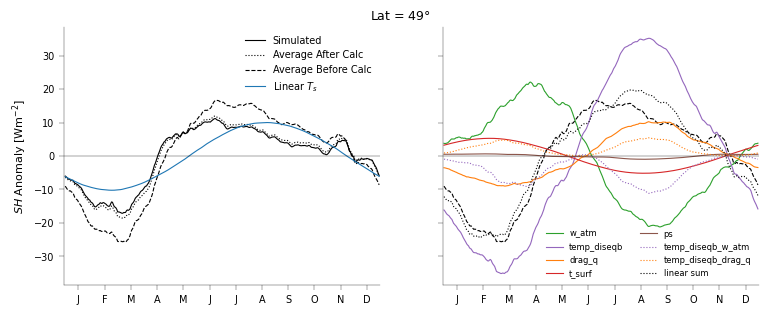

In [29]:
fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(ds.time, smooth_func(ds.flux_t.isel(lat=plot_lat_ind)-ds.flux_t.isel(lat=plot_lat_ind).mean()), color='k', label='Simulated')

ax[0].plot(ds.time, smooth_func(sh_manual['all_cont'].isel(lat=plot_lat_ind)-sh_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
        linestyle=':', label='Average After Calc')
ax[0].plot(ds.time, smooth_func(sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                             sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--',
        label='Average Before Calc')
ax[0].plot(ds.time, gamma_comp['sh']['linear'][plot_lat_ind]-gamma_comp['sh']['linear'][plot_lat_ind].mean(), color=default_colors[0],
           label='Linear $T_s$')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()

ax[1].plot(ds.time, smooth_func(sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                             sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--')
for key in ['w_atm', 'temp_diseqb', 'drag_q', 't_surf', 'ps']:
    ax[1].plot(ds.time, smooth_func((sh_taylor[key]*(ds[key]-ds_mean[key])).isel(lat=plot_lat_ind)), label=key, color=color_var[key])
if is_wishe:
    ax[1].plot(ds.time,
               smooth_func((sh_taylor['temp_diseqb_w_atm']*(ds['temp_diseqb']-ds_mean['temp_diseqb'])*
                            (ds['w_atm']-ds_mean['w_atm'])).isel(lat=plot_lat_ind)),
               label='temp_diseqb_w_atm', color=color_var['temp_diseqb'], linestyle=':')
    ax[1].plot(ds.time,
               smooth_func((sh_taylor['temp_diseqb_drag_q']*(ds['temp_diseqb']-ds_mean['temp_diseqb'])*
                            (ds['drag_q']-ds_mean['drag_q'])).isel(lat=plot_lat_ind)),
               label='temp_diseqb_drag_q', color=color_var['drag_q'], linestyle=':')
ax[1].plot(ds.time, smooth_func(sh_taylor['sum'].isel(lat=plot_lat_ind)-sh_taylor['sum'].isel(lat=plot_lat_ind).mean()), 
           color=color_var['sum'], linestyle=':', label='linear sum')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(ncol=2, fontsize=6)

ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$SH$ Anomaly [Wm$^{-2}$]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Longwave
#### Emission factor, $\epsilon$
If we say that the longwave emission is given by $\sigma \epsilon T_{a}^4(t)$, this gives an equation for $\epsilon(t) = \frac{LW^{\downarrow}}{\sigma T_a^4}$.

**Seasonal variation in $\epsilon$ is due to lapse rate varying throughout the year.**

In general, $\epsilon$, is a function of optical depth of the atmosphere, as well as atmospheric temperature. This is because $LW^{\downarrow}$ is equal to the radiation reaching the bottom atmospheric level (function of atmospheric temperature and optical depth of upper atmosphere) minus amount absorbed by the bottom atmospheric level (function of optical depth of single level) plus amount emitted by bottom atmospheric level (optical thickness of bottom level multiplied by $\sigma T^4$). 

We see that $\epsilon$ is largest when surface temperature is smallest. This makes sense from Henry 2021b, because in the winter, the lower atmosphere is warmer than the surface, hence emission temperature should be closer to the surface. In the summer however, surface is warmer than the atmosphere and so expect small emission temperature.

The hysteresis is much clearer here, I think it arises due to the advective component. In April and May, sun is moving towards higher latitudes, so pole is colder than surroundings, and thus you advect warmer air from the south increasing the low level atmospheric temperature resulting in a large $\epsilon$. In December and January, sun is moving south so now less of a temperature gradient to the south and low level atmospheric temperature is not increased much by advection, resulting in small $\epsilon$.

This hysteresis is not apparent in the summer because the summer is in radiative-convective equilibrium.

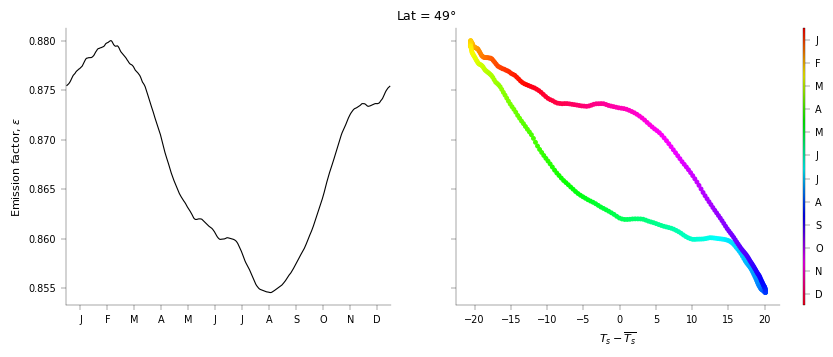

In [59]:
fig, ax = plt.subplots(1,2, figsize=(2*1.5*width['one_col'], 1.5*width['one_col']/ar), sharey=True)
ax[0].plot(ds.time, smooth_func(ds.emission_factor[:, plot_lat_ind]), color='k')
im = ax[1].scatter(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(ds.emission_factor[:, plot_lat_ind]), c=ds.time, cmap='hsv')
ax[0].set_xlim(-1, 360)
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Emission factor, $\epsilon$')
ax[1].set_xlabel('$T_s - \overline{T_s}$')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

#### Taylor Expansion
The equation for sensible heat is: $LW^{\uparrow}-LW^{\downarrow} = \sigma(T_s^4-\epsilon T_a^4)$

So it is only a function of 3 variables:

* Surface temperature, $T_s$
* Disequilibrium temperature, $T_{diseqb}$
* Emission factor, $\epsilon$

Below we investigate the relative contribution of each of these factors in a taylor series expansion.

In [31]:
def get_longwave_net(temp_surf, temp_diseqb, emission_factor):
    temp_a = temp_surf - temp_diseqb
    return Stefan_Boltzmann * (temp_surf**4 - emission_factor * temp_a**4)

In [32]:
lw_manual = {'all_cont': get_annual_zonal_mean(get_longwave_net(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].emission_factor)),
             'all_cont_av_first': get_longwave_net(ds.t_surf, ds.temp_diseqb, ds.emission_factor),
             'mean': get_longwave_net(ds_mean.t_surf, ds_mean.temp_diseqb, ds_mean.emission_factor)}
lw_taylor = {'t_surf': 4 * Stefan_Boltzmann * (ds_mean.t_surf ** 3 - ds_mean.emission_factor * ds_mean.temp**3),
             'temp_diseqb': 4 * Stefan_Boltzmann * ds_mean.emission_factor * ds_mean.temp**3,
             'emission_factor': -Stefan_Boltzmann * ds_mean.temp ** 4, 
             'sum': 0}
for key in lw_taylor:
    if key=='sum':
        continue
    lw_taylor['sum'] += (lw_taylor[key]*(ds[key]-ds_mean[key]))
lw_taylor['sum'] = lw_taylor['sum'] + lw_manual['mean']
# temp_diseqb has the largest influence so consider non-linear terms involving it
lw_taylor['t_surf_square'] = 12 * Stefan_Boltzmann * (ds_mean.t_surf ** 2 - ds_mean.emission_factor * ds_mean.temp**2)
lw_taylor['t_surf_square'] = lw_taylor['t_surf_square'] * 0.5
lw_taylor['t_surf_temp_diseqb'] = 12 * Stefan_Boltzmann * ds_mean.emission_factor * ds_mean.temp**2

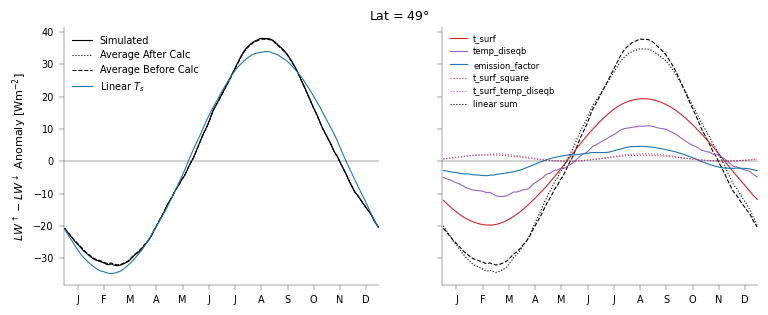

In [33]:
fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(ds.time, smooth_func(ds.lw_net.isel(lat=plot_lat_ind)-ds.lw_net.isel(lat=plot_lat_ind).mean()), color='k', label='Simulated')

ax[0].plot(ds.time, smooth_func(lw_manual['all_cont'].isel(lat=plot_lat_ind)-lw_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
        linestyle=':', label='Average After Calc')
ax[0].plot(ds.time, smooth_func(lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                             lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--',
        label='Average Before Calc')
ax[0].plot(ds.time, gamma_comp['lw']['linear'][plot_lat_ind]-gamma_comp['lw']['linear'][plot_lat_ind].mean(), color=default_colors[0],
           label='Linear $T_s$')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()

ax[1].plot(ds.time, smooth_func(lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind)-
                                lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k', linestyle='--')
for key in ['t_surf', 'temp_diseqb', 'emission_factor']:
    ax[1].plot(ds.time, smooth_func((lw_taylor[key]*(ds[key]-ds_mean[key])).isel(lat=plot_lat_ind)), label=key, color=color_var[key])
ax[1].plot(ds.time,
           smooth_func((lw_taylor['t_surf_square']*(ds['t_surf']-ds_mean['t_surf'])**2).isel(lat=plot_lat_ind)),
           label='t_surf_square', color=color_var['t_surf'], linestyle=':')
ax[1].plot(ds.time,
           smooth_func((lw_taylor['t_surf_temp_diseqb']*(ds['t_surf']-ds_mean['t_surf'])*
                        (ds['temp_diseqb']-ds_mean['temp_diseqb'])).isel(lat=plot_lat_ind)),
           label='t_surf_temp_diseqb', color=color_var['temp_diseqb'], linestyle=':')
ax[1].plot(ds.time, smooth_func(lw_taylor['sum'].isel(lat=plot_lat_ind)-lw_taylor['sum'].isel(lat=plot_lat_ind).mean()), 
           color=color_var['sum'], linestyle=':', label='linear sum')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(fontsize=6)

ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$LW^{\\uparrow} - LW^{\\downarrow}$ Anomaly [Wm$^{-2}$]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Relating variables to temperature
In the taylor series above, it appears that the variables other than `t_surf` have linear taylor series contributions that look similar to `t_surf`, and thus it seems we can do a polynomial fit of the other variables in terms of `t_surf` i.e. find coefficients $a$, $b$ and $b_{phase}$ such that $|v| \approx a + bT'(t) + b_{phase}T'(t-\mathcal{T}/4)$ for `w_atm`, and repeat for all 6 variables in the taylor expansions:

* Disequilibrium temperature, $T_{diseqb}$
* Relative humidity, $r_a$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$
* Emission factor, $\epsilon$

The fits are shown below, as well as the option to plot each variable's taylor series contribution to each flux (`show_flux_taylor=True`).

In [34]:
var_anom_approx_params = {key: np.zeros((n_lat, 3)) for key in ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps', 'emission_factor']}
var_anom_approx = {key: np.zeros((n_lat, n_time)) for key in var_anom_approx_params}
taylor_linear_coefs = {'lh': {key: lh_taylor[key].to_numpy() for key in lh_taylor if key in var_anom_approx}, 
                       'sh': {key: sh_taylor[key].to_numpy() for key in sh_taylor if key in var_anom_approx}, 
                       'lw': {key: lw_taylor[key].to_numpy() for key in lw_taylor if key in var_anom_approx}}
taylor_linear = {'lh': lh_taylor['sum'].to_numpy(),'sh': sh_taylor['sum'].to_numpy(), 'lw': lw_taylor['sum'].to_numpy()}
gamma_comp_taylor_approx_params = {'lh': {key: np.zeros((n_lat, 2)) for key in ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps']}, 
                                   'sh': {key: np.zeros((n_lat, 2)) for key in ['temp_diseqb', 'w_atm', 'drag_q', 'ps']}, 
                                   'lw': {key: np.zeros((n_lat, 2)) for key in ['temp_diseqb', 'emission_factor']}}
gamma_comp_taylor_approx = {key2: {key: np.zeros((n_lat, n_time)) for key in gamma_comp_taylor_approx_params[key2]} 
                            for key2 in gamma_comp_taylor_approx_params}
    
for i in range(n_lat):
    for key in var_anom_approx_params:
        var_anom_approx_params[key][i] = numerical.polyfit_phase(t_surf_anom[i], ds[key].isel(lat=i)-ds[key].isel(lat=i).mean(), 1, ds.time.to_numpy())
        var_anom_approx[key][i] = numerical.polyval_phase(t_surf_anom[i], var_anom_approx_params[key][i])
        for key2 in gamma_comp_taylor_approx:
            if key in gamma_comp_taylor_approx[key2]:
                gamma_comp_taylor_approx_params[key2][key][i] = taylor_linear_coefs[key2][key][i] * var_anom_approx_params[key][i][:2]
                # Add zero below because constant term in polyfit i.e. power 0 needs to be set to 0 as lh_taylor gives anomalies
                gamma_comp_taylor_approx[key2][key][i] = numerical.polyval_phase(t_surf_anom[i],
                                                                                 np.append(gamma_comp_taylor_approx_params[key2][key][i], 0))

# for t_surf make first param 0 as no phase shift for t_surf contribution to LH
gamma_comp_taylor_approx_params['lh']['t_surf'] = np.vstack((np.zeros(n_lat), lh_taylor['t_surf'].to_numpy())).transpose()
gamma_comp_taylor_approx_params['sh']['t_surf'] = np.vstack((np.zeros(n_lat), sh_taylor['t_surf'].to_numpy())).transpose()
gamma_comp_taylor_approx_params['lw']['t_surf'] = np.vstack((np.zeros(n_lat), lw_taylor['t_surf'].to_numpy())).transpose()
for key in gamma_comp_taylor_approx_params:
    gamma_comp_taylor_approx[key]['t_surf'] = gamma_comp_taylor_approx_params[key]['t_surf'][:, 1:] * t_surf_anom
    gamma_comp_taylor_approx_params[key]['sum'] = np.sum([gamma_comp_taylor_approx_params[key][key2] for key2 in 
                                                          gamma_comp_taylor_approx_params[key]], axis=0)
    gamma_comp_taylor_approx[key]['sum'] = np.sum([gamma_comp_taylor_approx[key][key2] for key2 in gamma_comp_taylor_approx[key]], axis=0)

gamma_comp_taylor_approx['lh']['sum'] = gamma_comp_taylor_approx['lh']['sum'] + lh_manual['mean'].to_numpy()[:, np.newaxis]
gamma_comp_taylor_approx['sh']['sum'] = gamma_comp_taylor_approx['sh']['sum'] + sh_manual['mean'].to_numpy()[:, np.newaxis]  
gamma_comp_taylor_approx['lw']['sum'] = gamma_comp_taylor_approx['lw']['sum'] + lw_manual['mean'].to_numpy()[:, np.newaxis]

In [35]:
# var_anom_approx_params = {key: np.zeros((n_lat, 3)) for key in ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps', 'emission_factor']}
# var_anom_approx = {key: np.zeros((n_lat, n_time)) for key in var_anom_approx_params}
# gamma_comp_taylor_approx_params = {'lh': {key: np.zeros((n_lat, 3)) for key in ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps']}, 
#                                    'sh': {key: np.zeros((n_lat, 3)) for key in ['temp_diseqb', 'w_atm', 'drag_q', 'ps']}, 
#                                    'lw': {key: np.zeros((n_lat, 3)) for key in ['emission_factor']}}
# gamma_comp_taylor_approx = {key2: {key: np.zeros((n_lat, n_time)) for key in gamma_comp_taylor_approx_params[key2]} 
#                             for key2 in gamma_comp_taylor_approx_params}
# lh_taylor_approx_params = {key: np.zeros((n_lat, 2)) for key in var_anom_approx_params}
# lh_taylor_approx = {key: np.zeros((n_lat, n_time)) for key in var_anom_approx_params}
# # for t_surf make first param 0 as no phase shift for t_surf contribution to LH
# lh_taylor_approx_params['t_surf'] = np.vstack((np.zeros(n_lat), lh_taylor['t_surf'].to_numpy())).transpose()
# lh_taylor_approx['t_surf'] = lh_taylor_approx_params['t_surf'][:, 1:] * t_surf_anom
# 
# for key in var_anom_approx_params:
#     for i in range(n_lat):
#         var_anom_approx_params[key][i] = numerical.polyfit_phase(t_surf_anom[i], ds[key].isel(lat=i)-ds[key].isel(lat=i).mean(), 1, ds.time.to_numpy())
#         var_anom_approx[key][i] = numerical.apply_polyfit_phase(t_surf_anom[i], var_anom_approx_params[key][i])
#         lh_taylor_approx_params[key][i] = float(lh_taylor[key][i]) * var_anom_approx_params[key][i][:2]
#         # Add zero below because constant term in polyfit i.e. power 0 needs to be set to 0 as lh_taylor gives anomalies
#         lh_taylor_approx[key][i] = numerical.apply_polyfit_phase(t_surf_anom[i], np.append(lh_taylor_approx_params[key][i], 0))
# lh_taylor_approx_params['sum'] = np.sum([lh_taylor_approx_params[key] for key in lh_taylor_approx_params], axis=0)
# lh_taylor_approx['sum'] = np.sum([lh_taylor_approx[key] for key in lh_taylor_approx], axis=0)

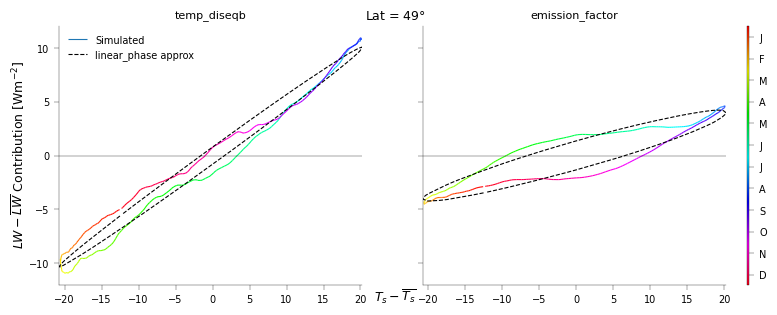

In [36]:
key_flux_plot = 'lw'
ignore_var_plot = ['ps']         # variables that you don't want to plot
show_flux_taylor = True       # if True will plot linear taylor series contribution to LH, otherwise will plot the variable
var_keys_plot = [key for key in gamma_comp_taylor_approx_params[key_flux_plot] if key!='t_surf' and key != 'sum' and key not in ignore_var_plot]
if len(var_keys_plot)>3:
    fig, ax = plt.subplots(2,int(np.ceil(len(var_keys_plot)/2)), 
                           figsize=(int(np.ceil(len(var_keys_plot)/2))*im_sz*width['one_col'], im_sz*2*width['one_col']/ar), sharex=True,
                           sharey=show_flux_taylor)
    ax = ax.flatten()
else:
    fig, ax = plt.subplots(1,len(var_keys_plot), figsize=(len(var_keys_plot)*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True,
                           sharey=show_flux_taylor)
    if len(var_keys_plot)==1:
        ax = [ax]
for i, key in enumerate(var_keys_plot):
    if show_flux_taylor:
        colored_line(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func((taylor_linear_coefs[key_flux_plot][key] * 
                                                                          (ds[key]-ds_mean[key])).isel(lat=plot_lat_ind)), c=ds.time, 
                     ax=ax[i], cmap='hsv', label='Simulated')
        ax[i].plot(t_surf_anom[plot_lat_ind], gamma_comp_taylor_approx[key_flux_plot][key][plot_lat_ind], color='k',
                   linestyle=linestyle_approx['linear_phase'], label='linear_phase approx') 
        ax[i].axhline(0, color='k', lw=ax_linewidth)
        ax[i].set_title(key)
    else:
        colored_line(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(ds[key].isel(lat=plot_lat_ind)), c=ds.time, 
                     ax=ax[i], cmap='hsv', label='Simulated')
        ax[i].plot(t_surf_anom[plot_lat_ind], var_anom_approx[key][plot_lat_ind]+float(ds[key].isel(lat=plot_lat_ind).mean()), color='k',
                   linestyle=linestyle_approx['linear_phase'], label='linear_phase approx')
        ax[i].set_ylabel(key+(f' {var_unit_labels[key]}' if var_unit_labels[key] is not None else ''))
ax[0].set_xlim(t_surf_anom[plot_lat_ind].min(), t_surf_anom[plot_lat_ind].max())
ax[0].legend()
if show_flux_taylor:
    fig.supylabel(f'${key_flux_plot.upper()} - \overline{"{"+key_flux_plot.upper()+"}"}$ Contribution '+'[Wm$^{-2}$]', fontsize=9, x=0.07)
fig.supxlabel('$T_s - \overline{T_s}$', fontsize=9, y=0.05)
cbar = fig.colorbar(im, ax=ax.ravel().tolist() if len(ax)>1 else ax[0], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Breakdown of $\lambda$ and $\lambda_{phase}$
Below for a given flux, I plot the contributions from the different variables to the final $\lambda$ and $\lambda_{phase}$, assuming a linear taylor series expansion. The appropriateness of the linear taylor series approximation can be seen by how closer the sum of all linear terms (black solid line) is to the empirical fit (black dotted line).

It is clear that $\lambda$ does not just come from the `t_surf` component of the linear taylor series expansion.

Text(0, 0.5, 'Feedback Parameter (phase), $\\lambda_{phase}$ [Wm$^{-2}K^{-1}$]')

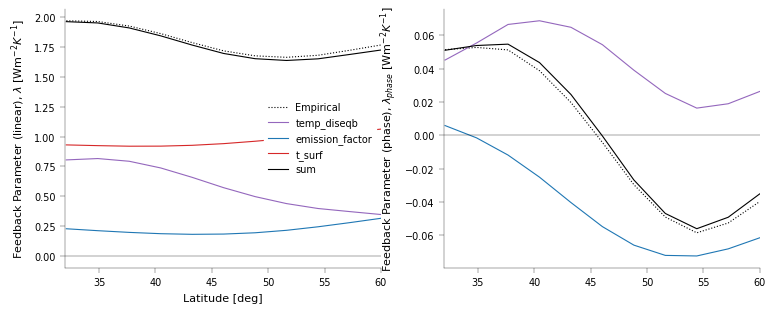

In [37]:
key_flux_plot = 'lw'
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(len(ax)):
    # for key2 in gamma_comp_params:
    ax[i].plot(ds.lat, gamma_comp_params[key_flux_plot]['linear_phase'][:, 1-i], color='k', label='Empirical', linestyle=':')
    for key in gamma_comp_taylor_approx_params[key_flux_plot]:
        if key == 't_surf' and i==1:
            continue
        ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot][key][:, 1-i], color=color_var[key], label=key)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend(ncol=1 if key_flux_plot=='lw' else 2, frameon=True, framealpha=1, edgecolor='white')
ax[0].set_xlim(ax_lims_lat)
ax[0].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Feedback Parameter (linear), $\lambda$ [Wm$^{-2}K^{-1}$]')
ax[1].set_ylabel('Feedback Parameter (phase), $\lambda_{phase}$ [Wm$^{-2}K^{-1}$]')
# fig.suptitle(f'{key_flux_plot.upper()}', fontsize=10, y=0.94)
# isca_tools.savefig(fig, f'{key_flux_plot}_param_breakdown', overwrite_file=True, save_if_exists=False)

### Appropriateness of Interpretation
The above interpretation, relies on the taylor series involving just the linear terms being accurate. The plot below investigates how good an approximation this is. 

The dotted line shows the error in the linear taylor series, which is fairly significant for sensible heat. 

The dashed line then shows the error in the linear taylor series, assuming each variable is related to temperature anomaly through the linear_phase fitting of $\lambda T'(t) + \lambda_{phase}T'(t-\mathcal{T}/4)$.

The solid line shows the error in directly fitting $\lambda T'(t) + \lambda_{phase}T'(t-\mathcal{T}/4)$ to explain the anomaly in the flux (doesn't give us any interpretation of which variables contribute to the two constants).

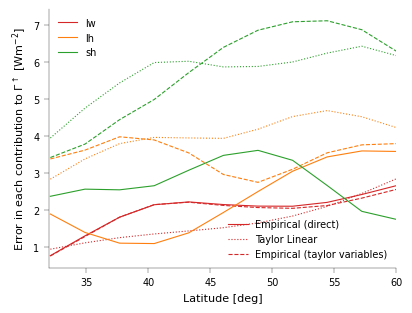

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
lines = []
for key in gamma_comp:
    lines += [ax.plot(ds.lat, error_func(smooth_func(gamma_comp[key]['simulated']-gamma_comp[key]['simulated'].mean(axis=1)[:, np.newaxis]),
                                         gamma_comp[key]['linear_phase']-gamma_comp[key]['linear_phase'].mean(axis=1)[:, np.newaxis], norm=False),
                      color=color_approx[key], label=key)[0]]
    lines += [ax.plot(ds.lat, error_func(smooth_func(gamma_comp[key]['simulated']-gamma_comp[key]['simulated'].mean(axis=1)[:, np.newaxis]), 
                                         smooth_func(taylor_linear[key]-taylor_linear[key].mean(axis=1)[:, np.newaxis]), norm=False),
                      color=color_approx[key], 
                      linestyle=':')[0]]
    lines += [ax.plot(ds.lat, error_func(smooth_func(gamma_comp[key]['simulated']-gamma_comp[key]['simulated'].mean(axis=1)[:, np.newaxis]),
                                         gamma_comp_taylor_approx[key]['sum']-gamma_comp_taylor_approx[key]['sum'].mean(axis=1)[:, np.newaxis],
                                         norm=False), color=color_approx[key],
                      linestyle='--')[0]]
        
legend1 = ax.legend(handles=lines[::3], loc="upper left")
ax.add_artist(legend1)  # Add the first legend manually

# Second legend
ax.legend(handles=lines[:len(gamma_comp)], loc="lower right", labels=['Empirical (direct)', 'Taylor Linear', 'Empirical (taylor variables)'])
ax.set_ylabel('Error in each contribution to $\Gamma^{\\uparrow}$ [Wm$^{-2}$]')
ax.set_xlim(ax_lims_lat)
ax.set_xlabel('Latitude [deg]');

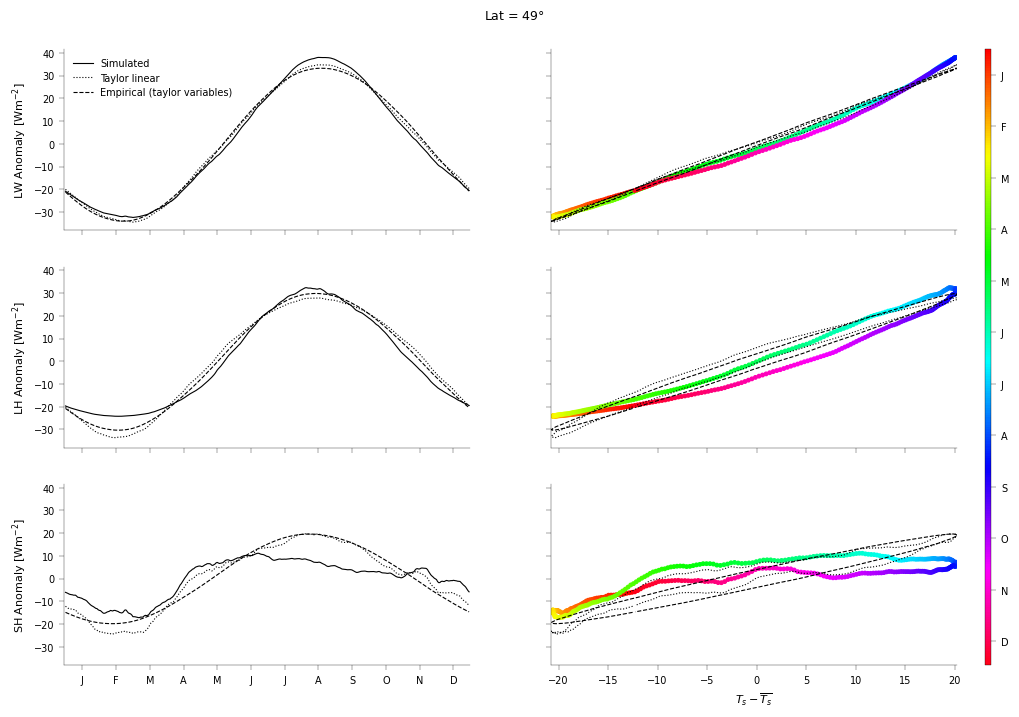

In [39]:
fig, ax = plt.subplots(3,2, figsize=(12, 8), sharey=True, sharex='col')
for i, key in enumerate(gamma_comp):
    ax[i, 0].plot(ds.time, smooth_func(gamma_comp[key]['simulated'][plot_lat_ind]-
                                       gamma_comp[key]['simulated'][plot_lat_ind].mean()), color='k', label='Simulated')
    im = ax[i, 1].scatter(smooth_func(t_surf_anom[plot_lat_ind]),
                          smooth_func(gamma_comp[key]['simulated'][plot_lat_ind]-gamma_comp[key]['simulated'][plot_lat_ind].mean()),
                          c=ds.time, cmap='hsv')
    for j, var in enumerate([taylor_linear[key], gamma_comp_taylor_approx[key]['sum']]):
        ax[i, 0].plot(ds.time, smooth_func(var-var.mean(axis=1)[:, np.newaxis])[plot_lat_ind],
                      color='k', linestyle=':' if j==0 else '--', label='Taylor linear' if j==0 else 'Empirical (taylor variables)')
        ax[i, 1].plot(t_surf_anom[plot_lat_ind], smooth_func(var-var.mean(axis=1)[:, np.newaxis])[plot_lat_ind],
                      color='k', linestyle=':' if j==0 else '--')
    ax[i, 0].set_ylabel(key.upper() + ' Anomaly [Wm$^{-2}$]')
    # fit_param = optimize.curve_fit(square_func, t_surf_anom[no_conv_time_ind], var[no_conv_time_ind], [80, 3, 0])[0]
    # ax[i, 0].plot(ds.time, square_func(t_surf_anom, *fit_param), color='g', linestyle='--', label='Square fit (non convecting)')
    # ax[i, 1].plot(t_surf_anom, square_func(t_surf_anom, *fit_param), color='g', linestyle='--')
ax[0, 0].set_xlim(-1, 360)
ax[0, 1].set_xlim(t_surf_anom[plot_lat_ind].min(), t_surf_anom[plot_lat_ind].max())
ax[0, 0].legend()
ax[-1, 0].set_xticks(*month_ticks)
ax[-1, 1].set_xlabel('$T_s - \overline{T_s}$')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);